In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [4]:
# === 0. LOAD RAW EXCEL (NO HEADER) ===
file_path = "/content/EDGAR_SO2_m_2000_2022.xlsx"

# Read everything as raw, no header
raw = pd.read_excel(file_path, header=None)

# Find the row where the actual header starts (first cell == 'IPCC_annex')
header_row_idx = raw.index[raw.iloc[:, 0] == "IPCC_annex"][0]
print("Header row index:", header_row_idx)

# Use that row as header, read again
df = pd.read_excel(file_path, header=header_row_idx)

print("Columns in raw:\n", df.columns.tolist())

Header row index: 9
Columns in raw:
 ['IPCC_annex', 'C_group_IM24_sh', 'Country_code_A3', 'Name', 'ipcc_code_2006_for_standard_report', 'ipcc_code_2006_for_standard_report_name', 'fossil_bio', 'Substance', 'Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [5]:
# ISO3 codes:
# Isolating only countries from synth
target_iso3 = ["PAK", "TJK", "IRQ", "MMR", "BGD"]

df_filt = df[
    (df["Country_code_A3"].isin(target_iso3)) &
    (df["Year"] >= 2008) &
    (df["Year"] <= 2022)
].copy()
print("\nCountries in filtered data:", df_filt["Country_code_A3"].unique())


Countries in filtered data: ['BGD' 'IRQ' 'MMR' 'PAK' 'TJK']


In [6]:
# Sum over all types
month_cols = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

group_cols = ["Country_code_A3", "Name", "Year", "Substance"]  # Substance should be SO2

df_monthly_totals = (
    df_filt
    .groupby(group_cols, as_index=False)[month_cols]
    .sum()
    .sort_values(["Country_code_A3", "Year"])
)

print("\nMonthly totals (wide) head:\n", df_monthly_totals.head())


Monthly totals (wide) head:
   Country_code_A3        Name  Year Substance        Jan        Feb  \
0             BGD  Bangladesh  2008       SO2  16.624120  15.047274   
1             BGD  Bangladesh  2009       SO2  13.548206  10.401080   
2             BGD  Bangladesh  2010       SO2  18.089526  11.020216   
3             BGD  Bangladesh  2011       SO2  23.221033  13.948638   
4             BGD  Bangladesh  2012       SO2  25.786192  21.621792   

         Mar        Apr        May        Jun        Jul        Aug  \
0   6.989176   6.186832   5.700169   5.974493   6.289112   5.248435   
1   6.619193   5.616700   5.246415   5.403896   5.570665   4.852357   
2   6.557901   6.030545   5.621367   5.811089   6.008266   5.190696   
3  10.488638   8.969244   8.196488   8.746540   9.354363   7.525593   
4  16.867791  13.972088  12.559763  13.744169  15.053167  11.449085   

         Sep        Oct        Nov        Dec  
0   5.546978   7.098718   8.664448  10.267630  
1   5.137586   6.239

In [7]:
# Save outputs
out_wide = "/content/SO2_monthly_PAK_TJK_IRQ_MMR_BGD_wide.csv"
df_monthly_totals.to_csv(out_wide, index=False)

print("\nSaved:")
print(out_wide)
print("/content/SO2_monthly_PAK_TJK_IRQ_MMR_BGD_wide.csv")


Saved:
/content/SO2_monthly_PAK_TJK_IRQ_MMR_BGD_wide.csv
/content/SO2_monthly_PAK_TJK_IRQ_MMR_BGD_wide.csv


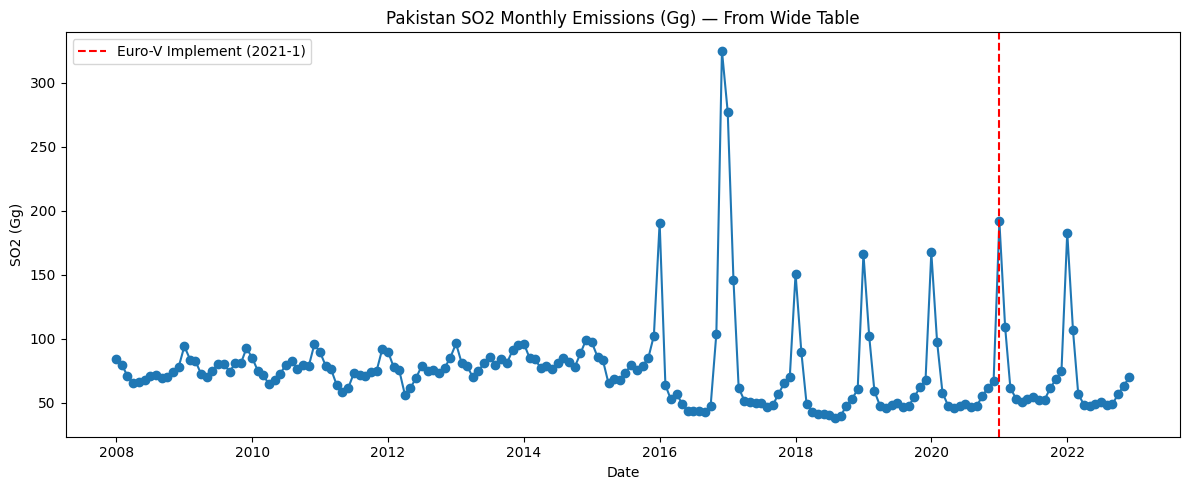

In [8]:
# Graph Pakistan
# === Select a country from the wide dataframe ===
pak = df_monthly_totals[df_monthly_totals["Country_code_A3"] == "PAK"].copy()

# Sort by year just to be sure
pak = pak.sort_values("Year")

# Months in order
month_cols = ["Jan","Feb","Mar","Apr","May","Jun",
              "Jul","Aug","Sep","Oct","Nov","Dec"]

# Create a datetime index for each row+month combination
dates = []
values = []

for _, row in pak.iterrows():
    year = row["Year"]
    for m, month in enumerate(month_cols, start=1):
        dates.append(pd.Timestamp(year=year, month=m, day=1))
        values.append(row[month])

# Now plot
plt.figure(figsize=(12,5))
plt.plot(dates, values, marker="o")
plt.axvline(pd.Timestamp("2021-01-01"), color="red", linestyle="--",
            label="Euro-V Implement (2021-1)")

plt.title("Pakistan SO2 Monthly Emissions (Gg) — From Wide Table")
plt.xlabel("Date")
plt.ylabel("SO2 (Gg)")
plt.tight_layout()
plt.legend()
plt.show()

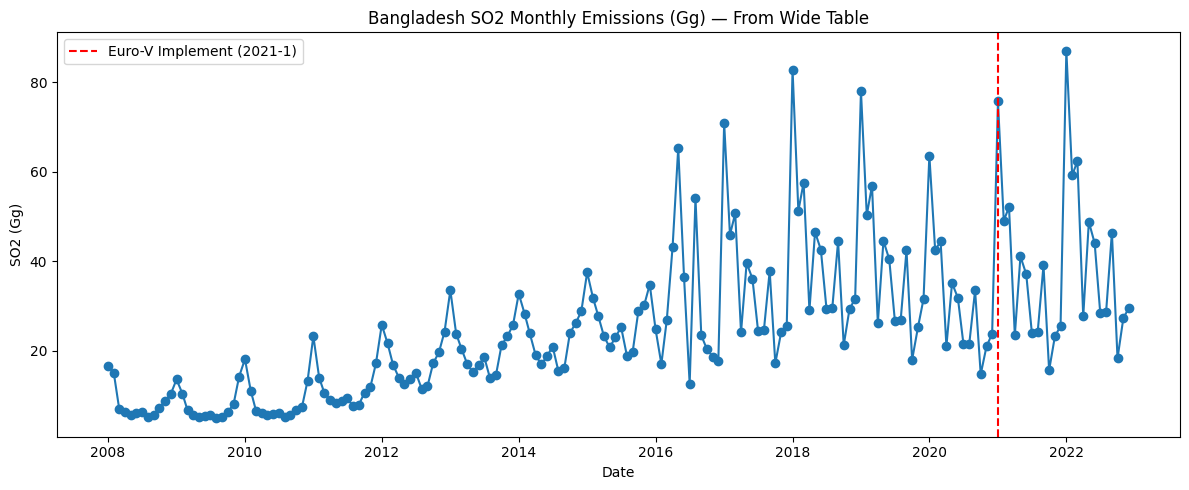

In [9]:
# Graph Bangladesh
# === Select a country from the wide dataframe ===
bgd = df_monthly_totals[df_monthly_totals["Country_code_A3"] == "BGD"].copy()

# Sort by year just to be sure
bgd = bgd.sort_values("Year")

# Months in order
month_cols = ["Jan","Feb","Mar","Apr","May","Jun",
              "Jul","Aug","Sep","Oct","Nov","Dec"]

# Create a datetime index for each row+month combination
dates = []
values = []

for _, row in bgd.iterrows():
    year = row["Year"]
    for m, month in enumerate(month_cols, start=1):
        dates.append(pd.Timestamp(year=year, month=m, day=1))
        values.append(row[month])

# Now plot
plt.figure(figsize=(12,5))
plt.plot(dates, values, marker="o")
plt.axvline(pd.Timestamp("2021-01-01"), color="red", linestyle="--",
            label="Euro-V Implement (2021-1)")

plt.title("Bangladesh SO2 Monthly Emissions (Gg) — From Wide Table")
plt.xlabel("Date")
plt.ylabel("SO2 (Gg)")
plt.tight_layout()
plt.legend()
plt.show()

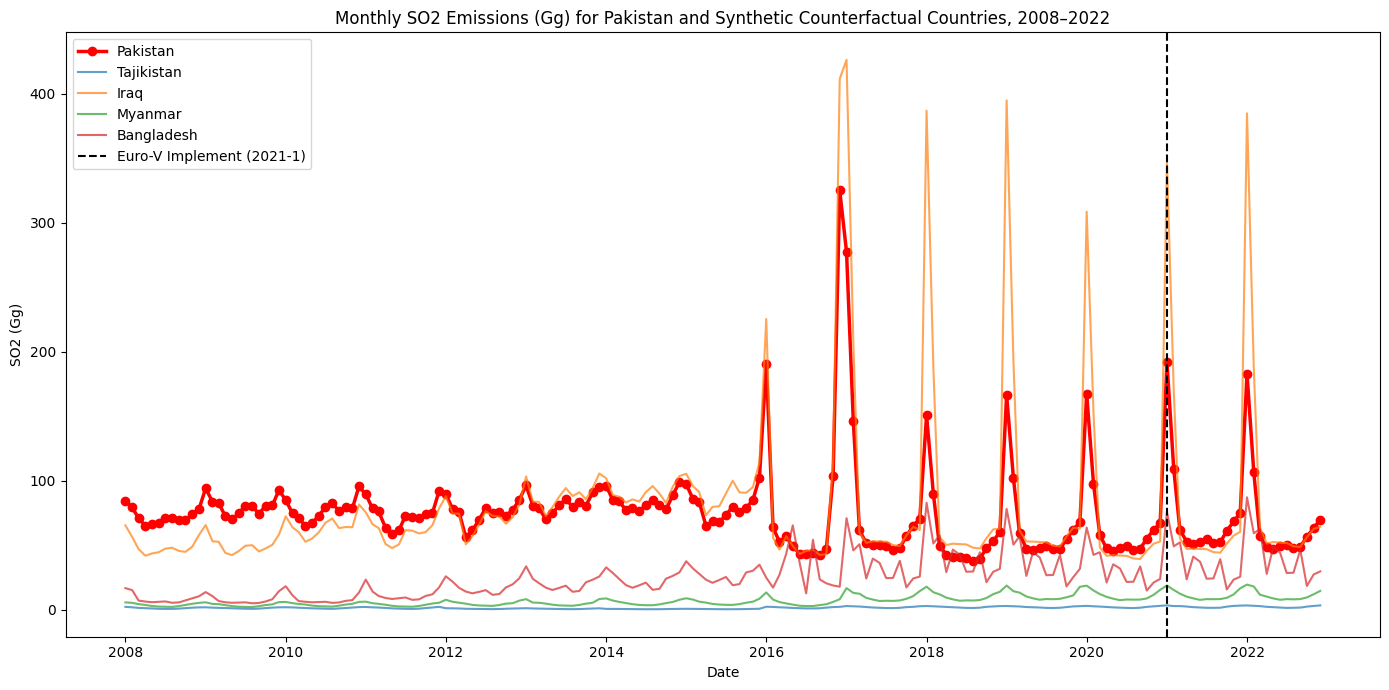

In [10]:
# --- PARAMETERS ---
month_cols = ["Jan","Feb","Mar","Apr","May","Jun",
              "Jul","Aug","Sep","Oct","Nov","Dec"]

countries = {
    "PAK": "Pakistan",
    "TJK": "Tajikistan",
    "IRQ": "Iraq",
    "MMR": "Myanmar",
    "BGD": "Bangladesh"
}

# --- CREATE FIGURE ---
plt.figure(figsize=(14,7))

for code, name in countries.items():
    # Filter each country's rows from the wide dataframe with year restriction
    df_c = df_monthly_totals[
        (df_monthly_totals["Country_code_A3"] == code) &
        (df_monthly_totals["Year"] >= 2008) &
        (df_monthly_totals["Year"] <= 2022)
    ].copy()

    df_c = df_c.sort_values("Year")

    dates = []
    values = []

    # build monthly sequence
    for _, row in df_c.iterrows():
        year = row["Year"]
        for m, month in enumerate(month_cols, start=1):
            dates.append(pd.Timestamp(year=year, month=m, day=1))
            values.append(row[month])

    # --- PLOT ---
    if code == "PAK":
        plt.plot(dates, values, label=name, linewidth=2.5, color="red", marker="o")
    else:
        plt.plot(dates, values, label=name, alpha=0.7)

# --- Euro-V vertical line
plt.axvline(pd.Timestamp("2021-01-01"), color="black", linestyle="--",
            label="Euro-V Implement (2021-1)")

# --- LABELING & DISPLAY ---
plt.title("Monthly SO2 Emissions (Gg) for Pakistan and Synthetic Counterfactual Countries, 2008–2022")
plt.xlabel("Date")
plt.ylabel("SO2 (Gg)")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
###########################################
# 1. Load SO2 Monthly Wide Dataset
###########################################
so2_path = "/content/SO2_monthly_PAK_TJK_IRQ_MMR_BGD_wide.csv"
df = pd.read_csv(so2_path)

print("SO2 columns:", df.columns.tolist())

# Rename to standard names: country, year
df = df.rename(columns={
    "Name": "country",
    "Year": "year"
})

# Make sure year is integer
df["year"] = df["year"].astype(int)

SO2 columns: ['Country_code_A3', 'Name', 'Year', 'Substance', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [1]:
###########################################
# 2. Load Population Excel Sheet
###########################################
pop_path = "/content/population.xlsx"
pop = pd.read_excel(pop_path)  # MUST contain: country, year, population

print("Population columns:", pop.columns.tolist())

# Rename to standard names: country, year, population
pop = pop.rename(columns={
    "Country": "country",
    "Year": "year",
    "Population": "population"
})

# Strip whitespace and fix types
pop["country"] = pop["country"].astype(str).str.strip()
pop["year"] = pop["year"].astype(int)
pop  = pop.loc[:, ~pop.columns.str.contains('^Unnamed')]

df["country"] = df["country"].astype(str).str.strip()

print("Population columns:", pop.columns.tolist())

NameError: name 'pd' is not defined

In [13]:
###########################################
# 3. Merge emissions with population
###########################################
df = df.merge(pop, on=["country", "year"], how="left")

# Check merge result
print(df[["country", "year", "population"]].head())
print("Any missing population?", df["population"].isna().any())

      country  year  population
0  Bangladesh  2008   149000000
1  Bangladesh  2009   151000000
2  Bangladesh  2010   152000000
3  Bangladesh  2011   154000000
4  Bangladesh  2012   155000000
Any missing population? False


In [14]:
###########################################
# 4. Per-Capita Normalization
###########################################
month_cols = ["Jan","Feb","Mar","Apr","May","Jun",
              "Jul","Aug","Sep","Oct","Nov","Dec"]

# Example: SO2 in kg per person (1 Gg = 1e6 kg)
for m in month_cols:
    df[f"{m}_kg_per_person"] = df[m] * 1e6 / df["population"]

In [15]:
###########################################
# 5. Save Normalized Output
###########################################
out_path = "/content/SO2_monthly_percapita_wide.csv"
df.to_csv(out_path, index=False)

print("Saved per-capita wide dataset to:")
print(out_path)
print(df.head())

Saved per-capita wide dataset to:
/content/SO2_monthly_percapita_wide.csv
  Country_code_A3     country  year Substance        Jan        Feb  \
0             BGD  Bangladesh  2008       SO2  16.624120  15.047274   
1             BGD  Bangladesh  2009       SO2  13.548206  10.401080   
2             BGD  Bangladesh  2010       SO2  18.089526  11.020216   
3             BGD  Bangladesh  2011       SO2  23.221033  13.948638   
4             BGD  Bangladesh  2012       SO2  25.786192  21.621792   

         Mar        Apr        May        Jun  ...  Mar_kg_per_person  \
0   6.989176   6.186832   5.700169   5.974493  ...           0.046907   
1   6.619193   5.616700   5.246415   5.403896  ...           0.043836   
2   6.557901   6.030545   5.621367   5.811089  ...           0.043144   
3  10.488638   8.969244   8.196488   8.746540  ...           0.068108   
4  16.867791  13.972088  12.559763  13.744169  ...           0.108824   

   Apr_kg_per_person  May_kg_per_person  Jun_kg_per_person  